# Convolutional Neural Networks

For this homework you will train a CNN on the Hymenoptera dataset that you can download from here:

- https://download.pytorch.org/tutorial/hymenoptera_data.zip

You will code any CNN architecture that you want for this, using pytorch and/or pytorch-lightning (you can use only pytorch is you want)

## Libraries and notebook methods

In [187]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from torch.utils.data import DataLoader, ConcatDataset
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms

import pdb
import pytorch_lightning as pl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.metrics import confusion_matrix
import scikitplot as skplt

import multiprocessing
import time
import os
import copy

from sklearn.metrics import (classification_report, roc_curve, 
                             precision_recall_curve, roc_auc_score, average_precision_score)

plt.ion()   # interactive mode

In [ ]:
workers = multiprocessing.cpu_count()

# Simple validation in case we have a GPU available
gpu = -1 if torch.cuda.is_available() else 0

num_epochs = 20

### Image display

In [201]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(12,12))
    plt.imshow(inp)
    plt.xticks(())
    plt.yticks(())
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

### Model performance metrics

In [203]:
cnn_arch_df = pd.DataFrame(columns=[
    'model', 
    'class', 
    'name', 
    'params', 
    'roc', 
    'auc', 
    'precision', 
    'recall', 
    'f1',
    'y_hat'
])

In [200]:
def get_model_size(model):
    return sum(p.numel() for p in model.parameters())

def get_predictions(model, loader):
    model.eval()
    all_preds = torch.tensor([]).detach()
    for batch in loader:
        imgs, _ = batch
        preds = model(imgs)
        all_preds = torch.cat((all_preds, preds), dim=0)
    scores = F.softmax(all_preds, dim=1)
    
    return scores.argmax(dim=1)

def get_roc_score(model, loader):
    y_test = loader.dataset.targets
    y_score = get_predictions(model, loader)
    return roc_auc_score(y_test, y_score)*100

def model_performance(model, loader, display=True):
    y_h = get_predictions(model, loader)
    msg = "Classification report for {}".format(type(model).__name__)
    #print(data.targets, y_h)
    y = loader.dataset.targets
    if display:
        print(msg)
        print("-" * len(msg))
        print(classification_report(y, y_h))
        skplt.metrics.plot_confusion_matrix(y, y_h, normalize=True, figsize=(10, 10))
        
    return classification_report(y, y_h, output_dict=True)

def append_architecture(df, model, loader):
    performance = model_performance(model, loader, display=False)['weighted avg']
    df = df.append({
        'class': type(model).__name__,
        'name': model.name,
        'params': "{:,}".format(get_model_size(model)),
        'auc': get_roc_score(model, loader),
        'precision': performance['precision'],
        'recall': performance['recall'],
        'f1': performance['f1-score'],
        'y_hat': get_predictions(model, loader)
    }, ignore_index=True)
    
    return df

### ROC AUC and Precision Recall Curves

In [194]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_roc_curve(y_test, y_score, title=None, label=None, legend=True, 
                   show_thresholds=True, colorbar=True):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    thresholds[0] = 1
    roc_auc = roc_auc_score(y_test, y_score)*100
    if label is None:
        label='ROC curve (area = {:.2f}%)'.format(roc_auc)
    else:
        
        label= label + ' auc = {:.2f}%'.format(roc_auc)
        
    if title is None:
        title = "ROC curve"

    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    
    if show_thresholds:
        norm = plt.Normalize(vmin=0, vmax=1)
        plt.plot(fpr, tpr, lw=1, label=label, alpha=0.7)
        plt.scatter(fpr, tpr, cmap=cm, c=thresholds, s=70, norm=norm)
        if colorbar:
            plt.colorbar()
    else:
        plt.plot(fpr, tpr, lw=3, label=label)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(title, fontsize=16)
    if legend:
        plt.legend(fontsize=12)

def plot_roc_curves(y_test, y_scores, labels, title=None, show_thresholds=True):
    for y_score, label in zip(y_scores, labels):
        plot_roc_curve(y_test, y_score, label=label, legend=False, 
                       show_thresholds=show_thresholds, colorbar=False)
    plt.legend(fontsize=12)
    if show_thresholds:
        plt.colorbar()
    if title is not None:
        plt.title(title, fontsize=16)     

In [195]:
def plot_pr_curve(y_test, y_score, title=None, label=None, legend=True, 
                   show_thresholds=True, colorbar=True):
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    precision = precision[:-1]
    recall = recall[:-1]
    avg_prec = average_precision_score(y_test, y_score)*100
    
    if label is None:
        label ='PR curve (area = {:.2f}%'.format(avg_prec)
    else:
        label = label + ' area = {:.2f}%'.format(avg_prec)
        
    if title is None:
        title = "PR curve"
    
    if show_thresholds:
        norm = plt.Normalize(vmin=0, vmax=1)
        plt.plot(recall, precision, lw=1, label=label, alpha=0.7)
        plt.scatter(recall, precision, cmap=cm, c=thresholds, s=70, norm=norm)
        if colorbar:
            plt.colorbar()
    else:
        plt.plot(recall, precision, lw=3, label=label)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title(title, fontsize=16)
    if legend:
        plt.legend(fontsize=12)

def plot_pr_curves(y_test, y_scores, labels, title=None, show_thresholds=True):
    for y_score, label in zip(y_scores, labels):
        plot_pr_curve(y_test, y_score, label=label, legend=False, 
                       show_thresholds=show_thresholds, colorbar=False)
    plt.legend(fontsize=12)
    if show_thresholds:
        plt.colorbar()
    if title is not None:
        plt.title(title, fontsize=16)   

## Dataset loading

**QUESTION.** Load the dataset into two dataloaders, one from training and the other for validation.

- You can use `torchvision.datasets.ImageFolder` and pass it to `DataLoader` for this, have a look at the documentation
- In the transformations, you should resize the images to make things faster (using the size of CIFAR-10's images for instance), and use some data augmentation (only for the training dataloader, of course) 

**QUESTION.** Display some images and their associated labels. You should see images of bees and ants :)

In [196]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
batchsize = 4

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), 
                            transform = data_transforms[x]) 
    for x in ['train', 'val']
}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batchsize, shuffle=True, num_workers=workers),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batchsize, shuffle=False, num_workers=workers)
}

dataset_sizes = {
    x: len(image_datasets[x]) 
    for x in ['train', 'val']
}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [197]:
print(image_datasets['train'])
print(image_datasets['val'])

Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 153
    Root location: hymenoptera_data/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


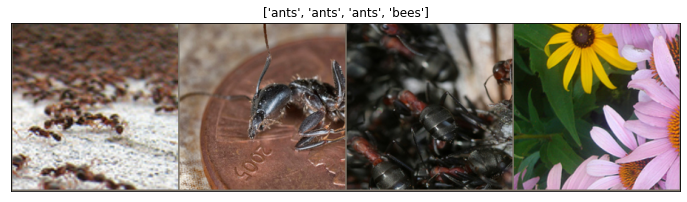

In [202]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Convolutional Neural Net Architecture

You are free to define any kind of convolutional neural network that you think is reasonable for today's problem.
Remember that convolutional neural networks are usually a combination of the following building blocks:

  * Convolutional layers
  * Pooling layers
  * Linear layers
  
It is your task today to arrange these components into a reasonable architecture.

In [8]:
class ConvNet(pl.LightningModule):

    def __init__(self, output_dim, model_name):

        super(ConvNet, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.ReLU(),
            
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            #nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, padding=1),
            #nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
#             nn.ReLU(),
#             #nn.BatchNorm2d(64),
#             nn.MaxPool2d(kernel_size=2),
            
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             #nn.BatchNorm2d(32),
#             #nn.MaxPool2d(kernel_size=2, stride=2),
            
#             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
#             nn.ReLU(),
#             #nn.BatchNorm2d(64),
#             nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=93312, out_features=600),
            nn.Dropout2d(0.2),
            nn.Linear(in_features=600, out_features=120),
            nn.Dropout2d(0.3),
            nn.Linear(in_features=120, out_features=output_dim)    
        )
        
        self.accuracy = pl.metrics.Accuracy()
        self.name = model_name
        
    def forward(self, x):
        out = self.encoder(x)
      #  print(out.shape)
        features = out.view(out.size(0), -1)
        #print(features.shape)
        logits = self.classifier(features)
        return logits
    
    def _step_util(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(F.softmax(logits, dim=1), y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "valid")

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=1e-3)

In [ ]:
net = ConvNet(output_dim = 2, model)

## Training loop and checks

**QUESTION**. Code the training loop (specify the loss, etc.). Check that everything is fine, that the forward pass works and that training on a very small subset of the data works as well. Add the callbacks that you want, and prepare the logging tools that you want to use (such as tensorboard, or anything you want to use.

In [11]:
print(net)

ConvNet(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=93312, out_features=600, bias=True)
    (1): Dropout2d(p=0.2, inplace=False)
    (2): Linear(in_features=600, out_features=120, bias=True)
    (3): Dropout2d(p=0.3, inplace=Fals

### Training check

In [ ]:
# Initialize a trainer
trainer = pl.Trainer(gpus=gpu, progress_bar_refresh_rate=20, fast_dev_run=True)

# Train the model ⚡
trainer.fit(net, train_dataloader=dataloaders['train'], val_dataloaders=dataloaders['val'])

### Training and Validation loop

In [15]:
trainer = pl.Trainer(gpus=gpu, max_epochs=num_epochs, progress_bar_refresh_rate=20)
trainer.fit(net, train_dataloader=dataloaders['train'], val_dataloaders=dataloaders['val'])

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 47.5 K
1 | classifier | Sequential | 56.1 M
2 | accuracy   | Accuracy   | 0     
------------------------------------------
56.1 M    Trainable params
0         Non-trainable params
56.1 M    Total params
224.431   Total estimated model params size (MB)


1

In [ ]:
cnn_arch_df = append_architecture(cnn_arch_df, net, dataloaders['val'])

## Performance of the models

Measure the performance of your model, and display some things (such as confusion matrix, ROC or AUC curves).
Compare several architectures, put your results in an easy to interpret pandas dataframe.

In [204]:
cnn_arch_df

,model,class,name,params,roc,auc,precision,recall,f1,y_hat


In [205]:
cnn_arch_df.drop('y_hat', axis=1)

,model,class,name,params,roc,auc,precision,recall,f1


Classification report for ConvNet
---------------------------------
              precision    recall  f1-score   support

           0       0.60      0.70      0.64        70
           1       0.70      0.60      0.65        83

    accuracy                           0.65       153
   macro avg       0.65      0.65      0.65       153
weighted avg       0.66      0.65      0.65       153



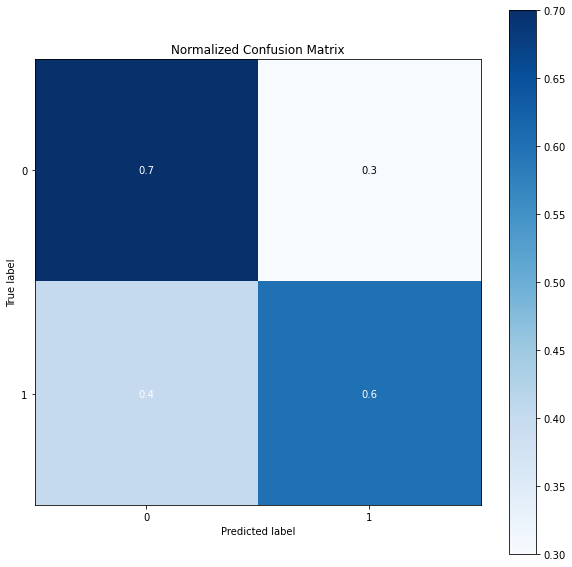

In [70]:
model_performance(net, image_datasets['val'], dataloaders['val'])

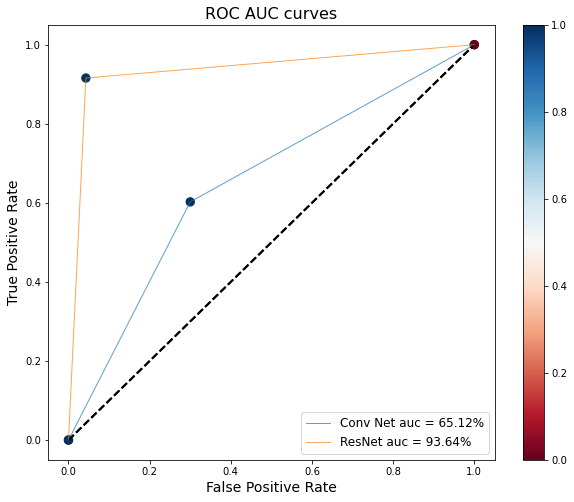

In [176]:
plt.figure(figsize=(10, 8))
plot_roc_curves(image_datasets['val'].targets, [get_predictions(net, dataloaders['val']), get_predictions(resnet, dataloaders['val'])], labels=["ConvNet", "ResNet"], title="ROC AUC curves")

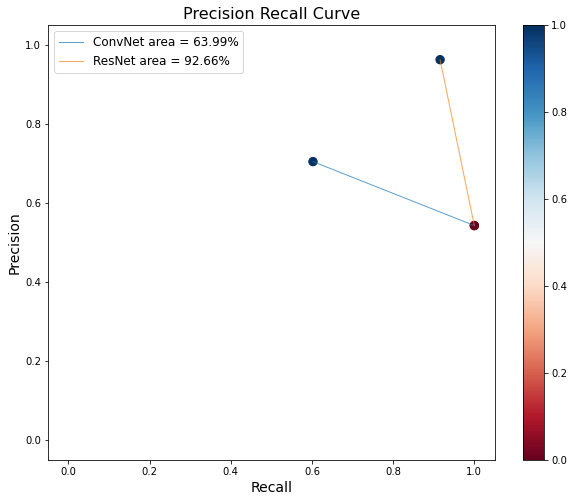

In [182]:
plt.figure(figsize=(10, 8))
plot_pr_curves(image_datasets['val'].targets, [get_predictions(net, dataloaders['val']), get_predictions(resnet, dataloaders['val'])], labels=["ConvNet", "ResNet"], title="Precision Recall Curves")

## Fine-tuning and transfer learning

You might have noticed that training a CNN from scratch can be very slow, hard, painful, and that the overall performance might not be satisfying. 

**QUESTION.** To overcome this, use a pre-trained network and fine-tune it on the Hymenoptera dataset.
You are free to choose any pre-trained model that the PyTorch library offers evaluate and compare its performance to the CNN you have built yourself.

### Pretrained architecture

In [62]:
class ResNet50(pl.LightningModule):

    def __init__(self, output_dim, model_name):

        super(ResNet50, self).__init__()
        self.feature_extractor = models.resnet50(pretrained=True)
        
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
            
        num_ftrs = self.feature_extractor.fc.in_features
        
        self.feature_extractor.fc = nn.Linear(num_ftrs, output_dim)
        
        self.accuracy = pl.metrics.Accuracy()
        
        self.name = model_name
    def forward(self, x):
        out = self.feature_extractor(x)
        return out
    
    def _step_util(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(F.softmax(logits, dim=1), y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        self.feature_extractor.train()
        return self._step_util(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        self.feature_extractor.eval()
        return self._step_util(batch, batch_idx, "valid")

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-3)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        return [optimizer], [scheduler]

In [63]:
resnet = ResNet50(output_dim=2)

### Training check

In [64]:
# Initialize a trainer
tl_trainer = pl.Trainer(gpus=gpu, progress_bar_refresh_rate=20, fast_dev_run=True)

# Train the model ⚡
tl_trainer.fit(resnet, train_dataloader=dataloaders['train'], val_dataloaders=dataloaders['val'])

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).

  | Name              | Type     | Params
-----------------------------------------------
0 | feature_extractor | ResNet   | 23.5 M
1 | accuracy          | Accuracy | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)


1

### Training and Validation Loop

In [65]:
tl_trainer = pl.Trainer(gpus=gpu, max_epochs=num_epochs, progress_bar_refresh_rate=20)
tl_trainer.fit(resnet, train_dataloader=dataloaders['train'], val_dataloaders=dataloaders['val'])

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name              | Type     | Params
-----------------------------------------------
0 | feature_extractor | ResNet   | 23.5 M
1 | accuracy          | Accuracy | 0     
-----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)


1

In [ ]:
cnn_arch_df = append_architecture(cnn_arch_df, resnet, "Resnet1", dataloaders['val'])

### Model performance

Classification report for ResNet50
----------------------------------
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        70
           1       0.96      0.92      0.94        83

    accuracy                           0.93       153
   macro avg       0.93      0.94      0.93       153
weighted avg       0.94      0.93      0.93       153



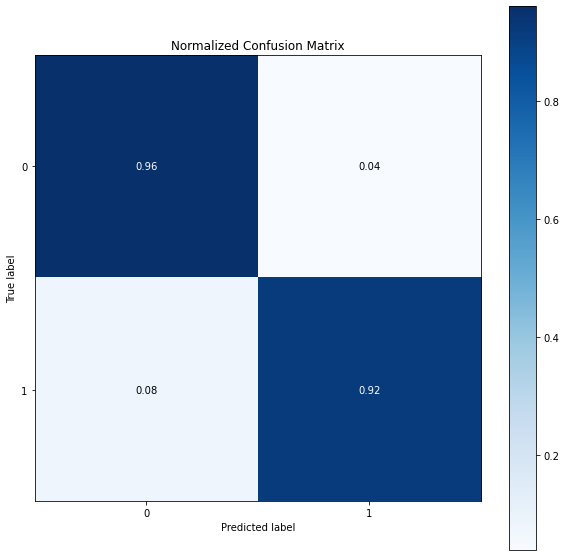

In [71]:
model_performance(resnet, image_datasets['val'], dataloaders['val'])

In [ ]:
plt.figure(figsize=(10, 8))
plot_roc_curves(image_datasets['val'].targets, [get_predictions(net, dataloaders['val']), get_predictions(resnet, dataloaders['val'])], labels=["ConvNet", "ResNet"], title="ROC AUC curves")

In [ ]:
plt.figure(figsize=(10, 8))
plot_pr_curves(image_datasets['val'].targets, [get_predictions(net, dataloaders['val']), get_predictions(resnet, dataloaders['val'])], labels=["ConvNet", "ResNet"], title="Precision Recall Curves")

In [46]:
def visualize_model(model, num_images=6):
    was_training = model.training
    print(was_training)
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                #print('predicted: {} real: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                ax.set_title('predicted: {} real: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [185]:
#visualize_model(resnet)
#plt.ioff()
#plt.show()